In [1]:
# NOTE: コメントワードクラウド

import json
import re

import pandas as pd
import requests

from googleapiclient.discovery import build

import collections
import copy
import json
import re

import MeCab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# markdown出力用
import pytablewriter
import requests
from wordcloud import WordCloud

# 必要モジュールのインポート
import os
from dotenv import load_dotenv

# .envファイルの内容を読み込見込む
load_dotenv()


API_KEY = os.environ['API_KEY']
BASE_URL = os.environ['BASE_URL']
FONT_PATH = os.environ['FONT_PATH']

import src.video_id as vid


# print(video_id.VIDEO_ID)

In [2]:
def get_videoTittle_from_videoId(videoId):
    youtube = build('youtube', 'v3', developerKey=API_KEY)
    videos_response = youtube.videos().list(
        part='snippet,statistics',
        id='{},'.format(videoId)
    ).execute()
    # snippet
    snippetInfo = videos_response["items"][0]["snippet"]
    # 動画タイトル
    return snippetInfo['title']

In [3]:
def get_comment_info(api_key, video_id, page_token):
    url = BASE_URL + 'commentThreads'
    param = {
        'key': api_key,
        'videoId': video_id,
        'part': 'replies, snippet',
        'maxResults': '100',
    }

    if page_token:
        param['pageToken'] = page_token

    response = requests.get(url, params=param)
    return response.json()

In [4]:
def get_video_comments(api_key, video_id):
    comments = []
    page_token = ''

    while page_token != None:
        resource = get_comment_info(api_key, video_id, page_token)

        for comment_thread in resource['items']:
            # コメント取得
            comment = comment_thread['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment)

            if ('replies' in comment_thread) and ('comments' in comment_thread['replies']):
                for replies in comment_thread['replies']['comments']:
                    # コメント取得
                    reply_comment = replies['snippet']['textDisplay']
                    comments.append(reply_comment)

        if 'nextPageToken' in resource:
            page_token = resource['nextPageToken']
        else:
            page_token = None
    return comments

# print(get_video_comments(API_KEY, vid.VIDEO_ID[0]))

In [5]:
# 特定の品詞の単語リストを取り出す
def get_word_class(text, kind='', min_len=1):
    word_list = []
    tagger = MeCab.Tagger()
    node = tagger.parseToNode(text)

    while node:
        word = node.surface
        pos = node.feature.split(',')[1]
        if (pos == kind) & (len(word) > min_len):
            word_list.append(word)
        node = node.next

    return word_list

In [ ]:
def get_noun_list(comments):
    all_noun = []

    # NOTE: 名詞を抽出する前にテキスト整形する
    # 改行タグの削除
    comments = list(map(lambda x: x.replace('<br />', ''), comments))

    for comment in comments:
        # aタグを消す
        reg = re.compile('<a.*/a>')
        atags = reg.findall(comment)
        for atag in atags:
            comment = comment.replace(atag, '')

        all_noun.extend(get_word_class(comment, kind='一般', min_len=1))

    return all_noun

print(get_noun_list(get_video_comments(API_KEY, vid.VIDEO_ID[0])))

In [7]:
# %%  ある動画に対するコメントを取得、解析する
def get_wc_from_comment(video_id, video_title):
    comments = get_video_comments(API_KEY, video_id)
    all_noun = get_noun_list(comments)
    stop_word_list = ["br", "is", "to", "this", "and", "the", "for", "can", "of", "her", "she", "are", "so", "quot", "be", "an", "you"]
    wc = WordCloud(background_color='white',
        font_path=FONT_PATH, width=900, height=500, collocations=False, stopwords=stop_word_list).generate(' '.join(all_noun))

    # wc.to_file('./wordcloud_{}.png'.format(video_title))
    plt.figure(figsize=(18,10))
    plt.axis("off")
    plt.imshow(wc)

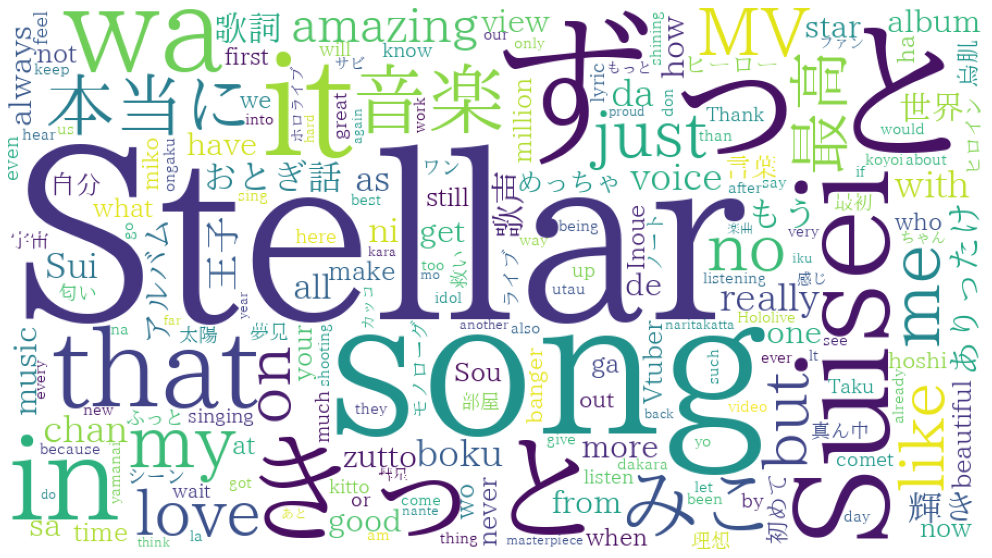

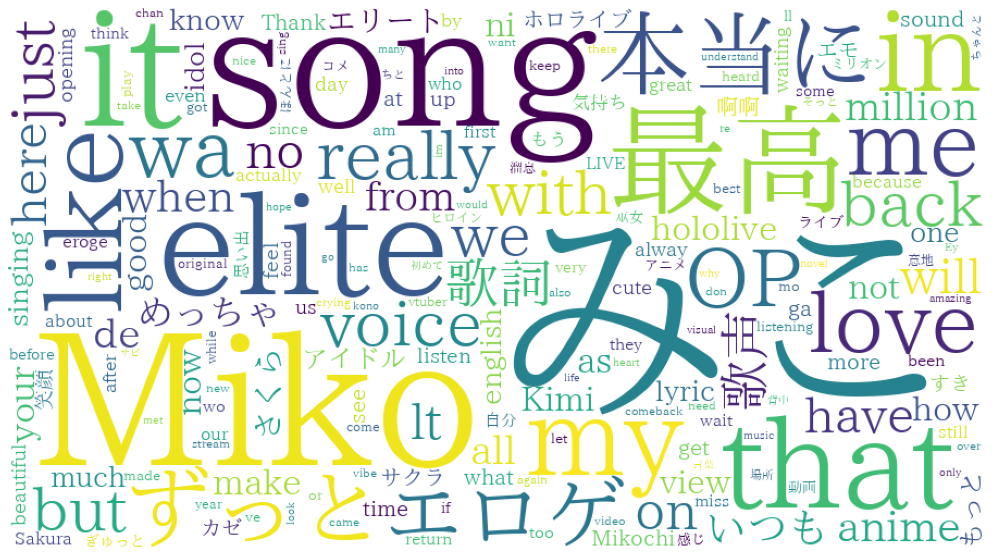

In [8]:
for id in vid.VIDEO_ID:
    get_wc_from_comment(id, get_videoTittle_from_videoId(id))